In [1]:
import sys
import os

galax_module_path = os.path.abspath(os.path.join('..'))
if galax_module_path not in sys.path:
    sys.path.append(galax_module_path)

import galaxies_data as galax
from matplotlib import pyplot as plt
import tensorflow.compat.v2 as tf
import functools
from absl import logging
import pandas as pd
import tensorflow_addons as tfa
import albumentations as A

/home/pedri0/anaconda3/envs/SIM/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20201129). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [2]:
def bulid_input_fn(global_batch_size):
    #Build input function.
    #Args:
    #    global_batch_size: Global batch size.
    #Returns:
    #    A function that accepts a dict of params and returns a tuple of images and
    #    features, to be used as the input_fn in TPUEstimator.
    def _input_fn_(input_context):
        #Inner input function
        batch_size = input_context.get_per_replica_batch_size(global_batch_size)
        logging.info('Global batch size: %d', global_batch_size)
        logging.info('Per-replica batch size: %d', batch_size)
        preprocess_fn_pretrain = get_preprocess_fn(True, is_pretrain=True)
        num_classes = 5

        def map_fn(image, label):
            #Produces multiple transformations of the same batch for pretraining
            xs = []
            for _ in range(2):
                xs.append(preprocess_fn_pretrain(image))
            image = tf.concat(xs, -1)
            label = tf.one_hot(label, num_classes)
            return image, label

        logging.info('Using Astro pretrain data')
        dataset = get_data_train()

        if input_context.num_input_pipelines > 1:
            dataset = dataset.shard(input_context.num_input_pipelines, input_context.input_pipeline_id)

        dataset = dataset.shuffle(batch_size * 10)
        dataset = dataset.repeat(-1)
        dataset = dataset.map(map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

    return _input_fn_

def build_distributed_dataset(batch_size, strategy):
    input_fn = bulid_input_fn(batch_size)
    return strategy.distribute_datasets_from_function(input_fn)

def get_preprocess_fn(is_training, is_pretrain):
    #Get function that accepts an image and returns a preprocessed image
    test_crop=True
    return functools.partial(
        preprocess_image,
        height = 330,
        width= 330,
        color_distort=is_pretrain)


def get_data_train():
    logging.info('Loading Astro pretrain data')
    data_dir = '/home/pedri0/Documents/imagenes_no_clasificadas_desi/'
    def read_images(image_file, label):
        image = tf.io.read_file(data_dir + image_file)
        image = tf.image.decode_jpeg(image, channels = 3)
        return image, label
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    df = pd.read_csv('/home/pedri0/Documents/GitHub/Modified-SimCLR/SimCLRTF2/galaxies_train.csv')
    file_paths = df['name'].values
    labels = tf.zeros([df.shape[0]], dtype=tf.int64)
    ds_train = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds_train = ds_train.map(read_images, num_parallel_calls =AUTOTUNE)
    return ds_train

In [3]:
CROP_PROPORTION = 0.55
def random_brightness(image, max_delta):
    #Only multiplicative change of brightness
    factor = tf.random.uniform([], tf.maximum(1.0-max_delta, 0), 1.0+max_delta)
    image = image * factor
    return image


def color_jitter_rand(image, brightness=0, contrast=0, saturation=0, hue=0):
    #Distorts the color of the image (jittering order is random)
    with tf.name_scope('distort_color'):
        def apply_transform(i,x):
            #apply the i-th transformation
            def brightness_foo():
                if brightness == 0:
                    return x
                else:
                    return random_brightness(x, max_delta=brightness)
            
            def contrast_foo():
                if contrast == 0:
                    return x
                else:
                    return tf.image.random_contrast(x, lower=1-contrast, upper=1+contrast)
            
            def saturation_foo():
                if saturation == 0:
                    return x
                else:
                    return tf.image.random_saturation(x, lower=1-saturation, upper=1+saturation)

            def hue_foo():
                if hue == 0:
                    return x
                else:
                    return tf.image.random_hue(x, max_delta = hue)
                
            def equalize_foo():
                return tfa.image.equalize(image)
            
            def motion_blur_foo():
                return 
            
            x = tf.cond(tf.less(i, 2),
                lambda: tf.cond(tf.less(i, 1), brightness_foo, contrast_foo),
                lambda: tf.cond(tf.less(i, 3), saturation_foo, hue_foo))
            return x

        perm = tf.random.shuffle(tf.range(4))
        for i in range(4):
            image = apply_transform(perm[i], image)
            image = tf.clip_by_value(image, 0., 1.)
        return image


def color_jitter(image, strength):
    #Distorts the color of the image
    #random_order: A bool, specifying whether to randomize the jittering order.
    brightness = 0.8 * strength
    contrast = 0.8 * strength
    saturation = 0.8 * strength
    hue = 0.2 * strength
    #removed color_jitter_nonrand
    return color_jitter_rand(image, brightness, contrast, saturation, hue)


def to_grayscale(image, keep_channels=True):
    image = tf.image.rgb_to_grayscale(image)
    if keep_channels:
        image = tf.tile(image, [1, 1, 3])
    return image


def random_apply(func, p, x):
    #Randomly apply function func to x with probability p.
    return tf.cond(tf.less(
        tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
        tf.cast(p, tf.float32)), lambda: func(x), lambda: x)


def random_color_jitter(image, p=1.0):

    def _transform(image):
        color_jitter_t = functools.partial(color_jitter, strength=1.0)
        image = random_apply(color_jitter_t, p=0.8, x=image)
        return random_apply(to_grayscale, p=0.2, x=image)
    
    return random_apply(_transform, p=p, x = image)


def random_crop(image, height, width):
    bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
    aspect_ratio = width / height
    shape = tf.shape(image)
    random_bounding_box = tf.image.sample_distorted_bounding_box(
        shape, bbox, aspect_ratio_range=(3. / 4 * aspect_ratio, 4. / 3. * aspect_ratio),
        use_image_if_no_bounding_boxes=True, area_range=(0.20,0.85))
    
    bound_box_begin, bound_box_size, _ = random_bounding_box
    offset_y, offset_x, _ = tf.unstack(bound_box_begin)
    target_height, target_width, _ = tf.unstack(bound_box_size)
    image = tf.image.crop_to_bounding_box(image, offset_y, offset_x, target_height, target_width)
    image = tf.image.resize([image], [height, width], method=tf.image.ResizeMethod.BICUBIC)[0]
    return image
        
def center_crop(image, height, width, crop_proportion):
    #Crops to center of image and rescales to desired size
    #removed original functions, the result is the same if we use this
    #instead of original func. (almost in our case) see transformations.py in the folder Notebooks_for_debug
    image = tf.image.central_crop(image, crop_proportion)

    return image


def preprocess_for_train(image, height, width, color_distort, flip=True):
    #Preprocesses the given image for train
    #center crop
    image = center_crop(image, height, width, crop_proportion=CROP_PROPORTION)
    #random_crop
    image = random_crop(image, height, width)
    if flip:
        image = tf.image.random_flip_left_right(image)
    if color_distort:
        image = random_color_jitter(image)
    image = image = tf.reshape(image, [height, width, 3])
    image = tf.clip_by_value(image, 0., 1.)
    return image


####################### Main function ##########################
def preprocess_image(image, height, width, color_distort=True):
    #color_distort: whether to apply the color distortion.
    #Returns A preprocessed image Tensor of range [0,1]
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return preprocess_for_train(image, height, width, color_distort)


######## added
def equalize_image(image):
    

SyntaxError: invalid syntax (<ipython-input-3-0b91933d393a>, line 41)

In [4]:
strategy = tf.distribute.MirroredStrategy()
ds = build_distributed_dataset(16, strategy)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


NameError: name 'preprocess_image' is not defined

In [58]:
def convert(img, target_type_min=0, target_type_max=255, target_type='uint8'):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

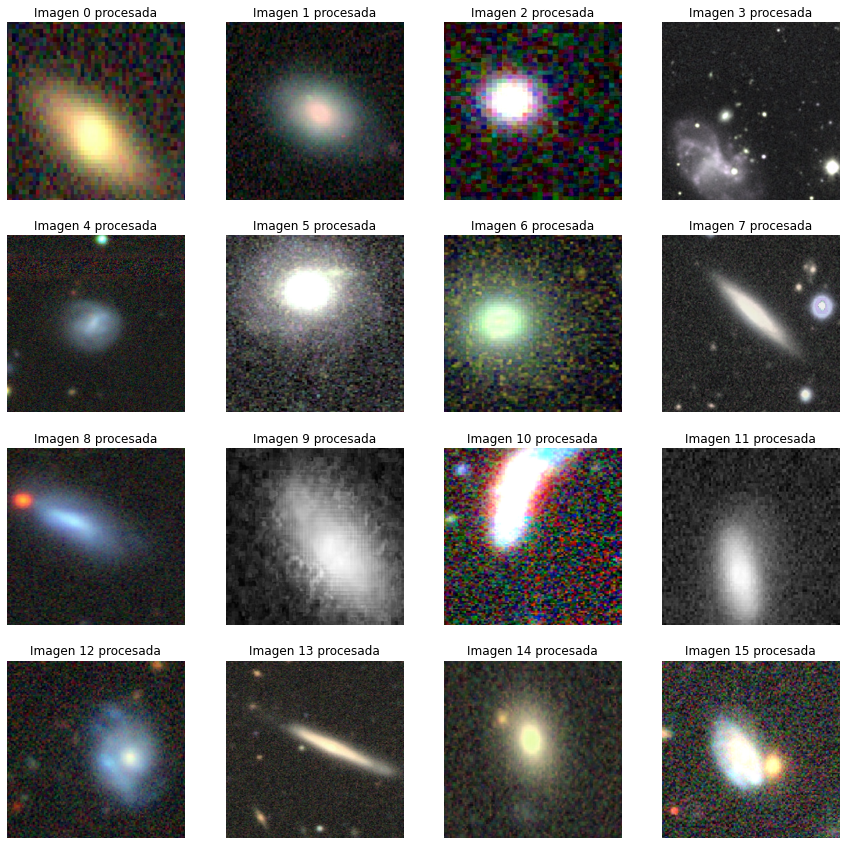

In [59]:
image_batch, label_batch = next(iter(ds))
images_from_0to3=[]
images_from_0to6=[]
for i in range(16):
    img1 = convert(image_batch[i,:,:,:3].numpy())
    img2 = convert(image_batch[i,:,:,3:].numpy())
    images_from_0to3.append(img1)
    images_from_0to6.append(img2)
plt.figure(figsize=(15, 15))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(images_from_0to3[i])
  #label = label_batch[i]
  plt.title('Imagen {} procesada'.format(i))
  plt.axis("off")

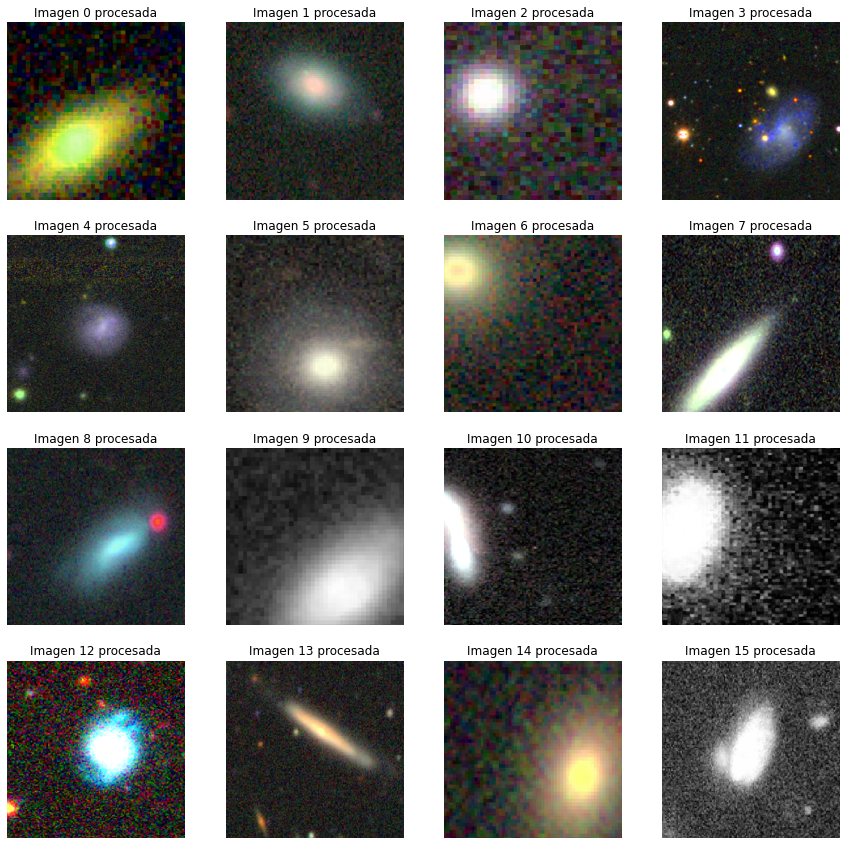

In [60]:
plt.figure(figsize=(15, 15))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(images_from_0to6[i])
  #label = label_batch[i]
  plt.title('Imagen {} procesada'.format(i))
  plt.axis("off")

In [85]:
image = tf.keras.preprocessing.image.load_img('J000047.88+141639.1.jpg')
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.convert_to_tensor(image)

In [87]:
equalized = tfa.image.equalize(image)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


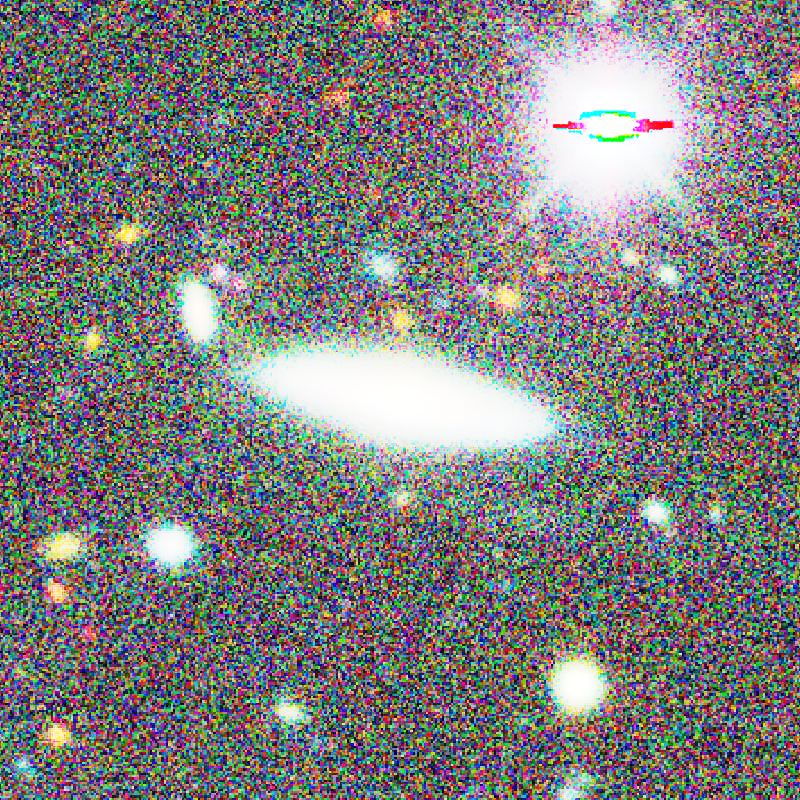

In [89]:
equalized = equalized.numpy()
equalized = tf.keras.preprocessing.image.array_to_img(equalized)
equalized

In [77]:
def color_jitter_rand(image, brightness=0, contrast=0, saturation=0, hue=0):
    #Distorts the color of the image (jittering order is random)
    with tf.name_scope('distort_color'):
        def apply_transform(i,x):
            #apply the i-th transformation
            def brightness_foo():
                if brightness == 0:
                    return x
                else:
                    return random_brightness(x, max_delta=brightness)
            
            def contrast_foo():
                if contrast == 0:
                    return x
                else:
                    return tf.image.random_contrast(x, lower=1-contrast, upper=1+contrast)
            
            def saturation_foo():
                if saturation == 0:
                    return x
                else:
                    return tf.image.random_saturation(x, lower=1-saturation, upper=1+saturation)

            def hue_foo():
                if hue == 0:
                    return x
                else:
                    return tf.image.random_hue(x, max_delta = hue)
            
            x = tf.cond(tf.less(i, 2),
                lambda: tf.cond(tf.less(i, 1), brightness_foo, contrast_foo),
                lambda: tf.cond(tf.less(i, 3), saturation_foo, hue_foo))
            return x

        perm = tf.random.shuffle(tf.range(4))
        for i in range(4):
            image = apply_transform(perm[i], image)
            image = tf.clip_by_value(image, 0., 1.)
        return image

<tf.Tensor: shape=(), dtype=bool, numpy=False>